<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/actual_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
!pip install tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.5 MB/s eta 0:00:00


In [3]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

In [38]:
from tokenizers.trainers import BpeTrainer
trainer = BpeTrainer(vocab_size=30, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

In [41]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

In [40]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
!unzip wikitext-103-raw-v1.zip

--2023-10-03 21:36:36--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.115.16, 52.216.107.166, 52.217.201.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.115.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191984949 (183M) [application/zip]
Saving to: ‘wikitext-103-raw-v1.zip.1’

text-103-raw-v1.zip  72%[=============>      ] 132.91M  42.5MB/s    eta 1s     ^C
Archive:  wikitext-103-raw-v1.zip
replace wikitext-103-raw/wiki.test.raw? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [42]:
files = [f"wikitext-103-raw/wiki.{split}.raw" for split in ["test", "train", "valid"]]
tokenizer.train(files, trainer)

In [43]:
tokenizer.save("tokenizer-wiki.json")

In [44]:
tokenizer = Tokenizer.from_file("tokenizer-wiki.json")

In [45]:
output = tokenizer.encode("Hello, y'all! How are you 😁 ?")
out_tensor = torch.tensor(output.ids)

In [46]:
out_tensor

tensor([44, 73, 80, 80, 83, 16, 93, 11, 69, 80, 80,  5, 44, 83, 91, 69, 86, 73,
        93, 83])

In [47]:
tokenizer.decode(out_tensor.numpy())

"H e l l o , y ' a l l ! H o w a r e y o"

In [72]:
import requests

a = requests.get("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt").text

with open("traintext.txt", 'wb') as d:
  d.writelines(a)

TypeError: ignored

In [48]:
with open("traintext.txt", 'r') as f:
  text = f.readlines()

In [49]:
text[:10]

[' \n',
 ' = Valkyria Chronicles III = \n',
 ' \n',
 ' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game 

In [50]:
import random

In [51]:
text_len = len(text) - 1

In [52]:
context_len = 20
emb_dim = 10
tokenizer.enable_truncation(context_len)
tokenizer.enable_padding(direction='left', length=context_len)

In [53]:
vocab_size = tokenizer.get_vocab_size()

pretokenize? aaaa but it takes so long

In [19]:
#text = torch.tensor([tokenizer.encode(t).ids for t in text])

In [54]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [55]:
def make_batch(batch):
  xs = []
  ys = []
  for sentence in batch:
    context = ""
    for word, next in zip(sentence, sentence[1:]):
      context += word
      xs.append(tokenizer.encode(context).ids)
      ys.append(torch.argmax(torch.tensor(tokenizer.encode(word).ids)))
  return torch.tensor(xs).to(device), torch.tensor(ys).to(device)

In [56]:
C = torch.randn((vocab_size, emb_dim)).to(device)
w1 = torch.randn((emb_dim * context_len, 100)).to(device) * 0.1
b1 = torch.randn(100).to(device) * 0.01
w2 = torch.randn((100, vocab_size)).to(device) * 0.1
b2 = torch.randn(vocab_size).to(device) * 0.01

params = [C, w1, b1, w2, b2]
for p in params:
  p.requires_grad = True

In [57]:
import torch.nn.functional as F

In [58]:
num_epochs = 200
batch_size = 32
lr = 0.1

In [59]:
for epoch in range(num_epochs):
  batch = [text[random.randint(0, text_len)] for i in range(batch_size)]
  #words = torch.tensor([tokenizer.encode_batch(batch)[i].ids for i in range(batch_size)])
  x, y = make_batch(batch)

  emb = C[x].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = (l1 @ w2 + b2).tanh()
  loss = F.cross_entropy(out, y)

  for p in params:
    p.grad = None

  loss.backward()
  for p in params:
    p.data -= p.grad * lr
  if epoch % 10 == 0:
    print(loss.item())

8.888589859008789
7.832459449768066
7.928826808929443
7.708570957183838
7.672215938568115
7.689198970794678
7.664445400238037
7.678053855895996
7.662820339202881
7.642581939697266
7.645384311676025
7.647658824920654
7.644937515258789
7.643275737762451
7.651203155517578
7.636529445648193
7.6416425704956055
7.644646644592285
7.633767127990723
7.636414527893066


In [60]:
@torch.no_grad()
def forward(text):
  ins = text
  x = torch.tensor(tokenizer.encode(text).ids)
  emb = C[x].view(-1, emb_dim * context_len)
  l1 = (emb @ w1 + b1).tanh()
  out = (l1 @ w2 + b2).tanh()
  out = out.exp()
  out /= out.sum(1, keepdim=True)
  sampled = torch.multinomial(out, num_samples=1)
  return sampled

In [61]:
import matplotlib.pyplot as plt

In [62]:
lol = forward('hi')
print(lol)
tokenizer.decode_batch(lol.cpu().numpy())

tensor([[667]], device='cuda:0')


['Դ']

In [63]:
def cont(text, max_len=20):
  context = text
  for x in range(max_len):
    context += tokenizer.decode_batch(forward(context).cpu().numpy())[0]
  return context

cont("my name is ")

'my name is ﻉユĔ惑栾М森牧授Ꭶ齐世卒ズ⚳寻∤ከȝང'

In [67]:
tokenizer.encode("[UNK]").ids

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [68]:
tokenizer.get_vocab_size()

5011

5011? y doe

why did it learn chinese? It's really consistently chinese too. Maybe I need a smaller vocab size?

(array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         1.0596e+04],
        [1.2000e+01, 8.2000e+01, 1.6990e+03, ..., 1.7000e+03, 1.7120e+03,
         9.1900e+02],
        [2.0000e+00, 1.0130e+03, 1.8000e+01, ..., 1.1300e+03, 1.7800e+02,
         1.0000e+01],
        ...,
        [2.0000e+00, 6.0000e+00, 1.5000e+02, ..., 1.4840e+03, 2.1890e+03,
         3.2160e+03],
        [2.0000e+01, 1.6900e+02, 1.0500e+02, ..., 1.3420e+03, 2.4400e+03,
         2.0000e+00],
        [6.7900e+02, 1.3450e+03, 1.2800e+03, ..., 1.1560e+03, 9.0100e+02,
         1.4000e+01]]),
 array([-0.99719739, -0.79747784, -0.59775835, -0.3980388 , -0.19831927,
         0.00140026,  0.2011198 ,  0.40083933,  0.60055888,  0.80027837,
         0.99999791]),
 <a list of 5011 BarContainer objects>)

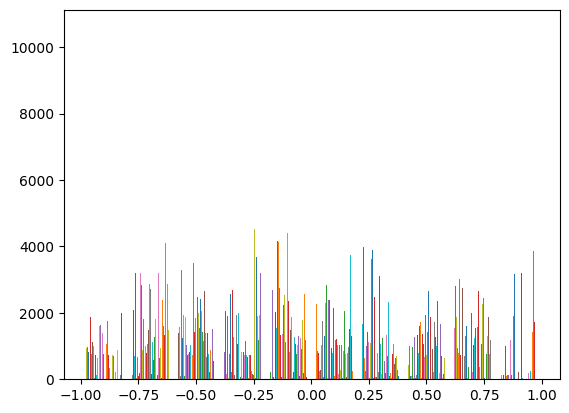

In [65]:
plt.hist(out.cpu().detach().numpy())